In [1]:
#@title << Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !git clone https://github.com/pxydi/text.git
        
    # Copy files required to run the code
    !cp -r "text/data" "text/plots" "text/tools.py" .
    
    # Install packages via pip
    !pip install -r "text/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

# Feature engineering for text

There are several different [approaches](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for extracting features from text. In this notebook, we will explore a few of them and discuss their strengths and weaknesses.  

We will be using the ***cleaned*** [Sentiment140](http://help.sentiment140.com/for-students/) twitter dataset that we prepared in the previous notebook. You can find it in the *data* folder.

We will be looking at the following feature extraction methods for text:

* Bag of words and Bag of n-grams  
* Tf-idf term weighting  
* Sentence embeddings

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os, re, random, string
from collections import defaultdict

# Gensim
import gensim
from gensim.models import Phrases

# Load helper functions
import tools

In [3]:
# Load processed dataset)

path = os.path.join('data','clean_sentiment_140.csv')
df   = pd.read_csv(path)

print('Data size: ',df.shape)

Data size:  (498, 4)


In [4]:
# Show a few samples

df.sample(5)

,tweet,processed_tweet,label,semantic_category
114,Ok so lots of buzz from IO2009 but how lucky are they - a Free G2!! http://is.gd/Hyzl,ok lot buzz io lucki free,pos,unlabeled
452,"I mean, I'm down with Notre Dame if I have to. It's a good school, I'd be closer to Dan, I'd enjoy it.",mean notr dame good school would closer dan would enjoy,pos,unlabeled
105,"i srsly hate the stupid twitter API timeout thing, soooo annoying!!!!! :(",srsli hate stupid twitter_api timeout thing sooo annoy :(,neg,Twitter
186,Your Normal Weight (and How to Get There) ? Normal Eating Blog http://bit.ly/ZeT8O,normal weight get normal eat blog,neutral,blogging
180,Bout to hit safeway I gotta eat,bout hit safeway got eat,neutral,food


## Bag of words

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the input text structure (word order, chapters, paragraphs, sentences, and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurrences leads to the mental image of representing text as a "bag".  

Computing the ***Bag of words*** representation for a corpus of documents consists of the following three steps:

* **Tokenization**: Split each document into the words that appear in it (called *tokens*), for example, by splitting them on whitespace.
* **Vocabulary building**: Collect all unique words that appear in any of the documents.
* **Count frequencies**: For each document, count how often each of the vocabulary words appears in this document.

The ***Bag of words*** model can be implemented with the *CountVectorizer* object from [*scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
my_regexp = '(?u)[a-z0-9:(_\)/;=\]\[<>-][a-z0-9:(_\)/;=\]\[<>-]+'

# Create an instance of CountVectorizer
vectorizer = CountVectorizer(token_pattern=my_regexp)

*Note: The CountVectorizer extracts tokens using the default regular expression (`(?u)\b\w\w+\b`). This regex pattern matches tokens of at least 2 alphanumeric characters, separated by word boundaries. This particular regular expression ignores the punctuation and treats it as a token separator. This doesn't suit our needs, as we would like a tokenizer which preserves emoticons (which are groupings of punctuation marks).*

*Therefore, we had to modify the `token_pattern` to keep emoticons in text.*

Let's test the Bag of words model on a toy corpus.

In [6]:
# Show toy corpus (before preprocessing)

print('Toy corpus:\n')
list(df['tweet'].iloc[[62,410,345]].values)

Toy corpus:



['Hello Twitter API ;)',
 "this dentist's office is cold :/",
 'obviously not siding with Cheney here: http://bit.ly/19j2d']

In [7]:
# Toy corpus (after cleaning)

X_toy = df['processed_tweet'].iloc[[62,410,345]].values

# Show toy corpus
print('Toy corpus (after cleaning):\n')
print(list(X_toy))

Toy corpus (after cleaning):

['hello twitter_api ;)', 'dentist offic cold :/', 'obvious not side cheney']


In [8]:
# X_bow: the bag-of-words representation of the tweets

X_bow_toy = vectorizer.fit_transform(X_toy)

# Show Bag of words vectors
df_BOW_toy = pd.DataFrame(X_bow_toy.toarray(), columns=vectorizer.get_feature_names())
df_BOW_toy['Text'] = X_toy
df_BOW_toy.set_index('Text',inplace=True)

print('Shape:      {}'.format(df_BOW_toy.shape))
df_BOW_toy.head()

Shape:      (3, 11)


,:/,;),cheney,cold,dentist,hello,not,obvious,offic,side,twitter_api
Text,,,,,,,,,,,
hello twitter_api ;),0,1,0,0,0,1,0,0,0,0,1
dentist offic cold :/,1,0,0,1,1,0,0,0,1,0,0
obvious not side cheney,0,0,1,0,0,0,1,1,0,1,0


Bag of words has converted all documents into lists of word counts.   
* Each column represents a word in the corpus.  
* Each row represents a document in the corpus.  
* Each cell represents the number of times a particular word (defined by a column) appears in a particular document (defined by a row). 

For example, 

* **:/** appears once in the second document and zero times in the other documents.  
* **hello twitter api ;)** is represented by this list of numbers: [0,1,0,0,0,1,0,0,0,0,1].


We describe each sample of text by word occurencies, completely ignoring the relative position of words in a document. The "meaning" of a document is defined as a list of numbers.

**Question : The shape of `X_bow_toy` is: (3,11). What does each dimension correspond to?**

In [9]:
# Write your answer here
#
# ...

Now, it's time to apply the Bag of words model on the whole corpus.

In [10]:
# Create array of texts
X = df['processed_tweet'].values

# Show a few samples from the corpus
print('Corpus:\n')
list(X[0:5])

Corpus:



['looovvvee kindl not dx cool fantast right',
 'read kindl love lee child good read',
 'ok first asses kindl fuck rock',
 'love kindl mine month never look back new big one huge no need remors :)',
 'fair enough kindl think perfect :)']

In [11]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer(token_pattern=my_regexp)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X)

print('Representing text as bag-of-words:\n')
print('Bag of words vectors:      {}'.format(X_bow.shape))

Representing text as bag-of-words:

Bag of words vectors:      (498, 1643)


The bag of words representation of the train data is a matrix of shape (498, 1643). Each row corresponds to a tweet and each column to a word in the *vocabulary*.

**Question : What is the size of the vocabulary?**

In [12]:
# Write your answer here
#
# ...

In [13]:
# Solution

# Lets have a look at the vocabulary

vocab = vectorizer.get_feature_names()
print('Vocabulary size: {}\n'.format(len(vocab)))

print('Show some words from the vocabulary:\n')
print(vocab[0:50])

Vocabulary size: 1643

Show some words from the vocabulary:

['(:', '):', ':(', ':)', ':-(', ':-)', ':-d', ':/', '::', ':]', ':d', ';(', ';)', ';p', '=(', '=)', '=/', '=]', '=d', 'aapl', 'absolut', 'access', 'accid', 'accord', 'accost', 'account', 'acg', 'ach', 'acia', 'across', 'actual', 'ad', 'adam', 'add', 'addict', 'adida', 'administr', 'admiss', 'adob', 'advanc', 'advic', 'aerospac', 'africa', 'afternoon', 'agenc', 'ago', 'ah', 'aha', 'ahead', 'ahh']


In [14]:
# Show Bag of words vectors

df_BOW = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names())
df_BOW.index = ['doc_'+str(i) for i in range(0,len(df_BOW))]
df_BOW.head()

,(:,):,:(,:),:-(,:-),:-d,:/,::,:],...,you-vers,youtub,yr,yuan,yummmi,zealot,zero,zomg,zoom,zydruna
doc_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In a typical corpus, the **Bag of words** model creates vectors that are ***long*** (10K - 1M) and ***sparse*** (most values are zero). This requires a lot of space and computational time to process. 

Later we will see an alternative method for representing documents as vectors that are ***short*** (of length 100 - 1'000) and ***dense*** (most values are non-zero).

**Question : How does min_df, max_df and max_features affect the size of the vocabulary?**

We can adjust the size of the vocabulary (hence the size of the vectors) by tuning the following (hyper)parameters: 
- max_features  
- min_df  
- max_df.

In [15]:
# Create an instance of CountVectorizer

vectorizer = CountVectorizer(min_df = 2,          # keep words that appear in at least min_df docs
                             max_df = 0.9,        # keep words that appear in at less than X% of docs
                             max_features = 300,  # keep only top-X most frequent words in the vocabulary
                             token_pattern=my_regexp)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X)

print('Representing text as bag-of-words:\n')
print('Train set:      {}'.format(X_bow.shape))

Representing text as bag-of-words:

Train set:      (498, 300)


In [16]:
# Show Bag of words vectors

df_BOW = pd.DataFrame(X_bow.toarray(),columns=vectorizer.get_feature_names())
df_BOW.index = ['doc_'+str(i) for i in range(0,len(df_BOW))]
df_BOW.head()

,:(,:),:d,;),ad,adob,aig,allen,alpha,alreadi,...,word,work,world,worst,worth,would,wtf,yay,ye,year
doc_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> **Bag-of-words** 
>
>✅ Simple   
>✅ Effective and commonly used to represent text for machine learning  
>
>
>🔴 Discards word order  
>🔴 Creates long (typical vocabulary  sizes: 20K - 1M) and sparse (mostly filled with zeros) vectors  
>🔴 Treats words as distinct "atomic" symbols; no natural notion of "word similarity" (e.g. "size" ≠ "capacity" or "hotel" ≠ "motel").

## Bag of n-grams

One of the disadvantages of the bag of words model is that word order is discarded. However, some information about the context of a text may be lying in combinations of words, not just single words. One way to capture context with the bag of words model is by considering pairs or triplets of words appearing next to each other in a sentence. Single words are called ***unigrams***, pairs of words ***bigrams***, triplets of words ***trigrams***, and more generally, sequences of tokens are called ***n-grams***. 

N-grams retain more of the original sequence structure in the text and can, in some cases, be more "informative".

**Example** : Let's use the Bag of n-grams model with the toy corpus from above.

In [17]:
list(X_toy)

['hello twitter_api ;)', 'dentist offic cold :/', 'obvious not side cheney']

In [18]:
# Bag of n-grams

pd.set_option('display.max_columns', 21)
vectorizer_n_grams = CountVectorizer(ngram_range=(1, 2),     # Considers unigrams and bigrams
                                     token_pattern=my_regexp) 

# X_ngram_toy: the bag of n-grams representation of the toy corpus
X_ngram_toy = vectorizer_n_grams.fit_transform(X_toy)

# Show Bag of words vectors
df_ngram_toy = pd.DataFrame(X_ngram_toy.toarray(), columns=vectorizer_n_grams.get_feature_names())
df_ngram_toy['Text'] = X_toy
df_ngram_toy.set_index('Text',inplace=True)
print('Shape:      {}'.format(df_ngram_toy.shape))
df_ngram_toy

Shape:      (3, 19)


,:/,;),cheney,cold,cold :/,dentist,dentist offic,hello,hello twitter_api,not,not side,obvious,obvious not,offic,offic cold,side,side cheney,twitter_api,twitter_api ;)
Text,,,,,,,,,,,,,,,,,,,
hello twitter_api ;),0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1
dentist offic cold :/,1,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0
obvious not side cheney,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0


With the Bag-of-Words model, we used to have a vocabulary of size 11 (toy corpus). With the Bag of n-grams, the size of the vocabulary is 19.

**Example** : Now, it's time to apply the bag of n-grams model to the whole corpus.

In [19]:
X = df['processed_tweet'].values

# Show a few samples from the corpus
print('Corpus:\n')
list(X[0:5])

Corpus:



['looovvvee kindl not dx cool fantast right',
 'read kindl love lee child good read',
 'ok first asses kindl fuck rock',
 'love kindl mine month never look back new big one huge no need remors :)',
 'fair enough kindl think perfect :)']

In [20]:
# Create an instance of CountVectorizer
vectorizer_n_grams = CountVectorizer(ngram_range=(1, 2),     # Considers unigrams and bigrams
                                     token_pattern=my_regexp) 

# X_ngram_toy: the bag of n-grams representation of the entire corpus
X_ngram = vectorizer_n_grams.fit_transform(X)

# Show Bag of words vectors
df_ngram = pd.DataFrame(X_ngram.toarray(),columns=vectorizer_n_grams.get_feature_names())
df_ngram['Text'] = X
df_ngram.set_index('Text',inplace=True)
print('Size:      {}'.format(df_ngram.shape))
df_ngram.head()

Size:      (498, 4740)


,(:,(: yeee,):,): fuck,:(,:( damn,:( get,:( oh,:( thing,:( time,...,yummmi,zealot,zealot could,zero,zero desir,zomg,zoom,zoom lebron,zydruna,zydruna awesom
Text,,,,,,,,,,,,,,,,,,,,,
looovvvee kindl not dx cool fantast right,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
read kindl love lee child good read,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ok first asses kindl fuck rock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
love kindl mine month never look back new big one huge no need remors :),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fair enough kindl think perfect :),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With the bag of words model, we used to have a vocabulary of size 1'638. With the bag of n-grams, we have a vocabulary of size 4'743.

**Question** : Mention a few ways for reducing the size of the vocabulary. Can you implement them in the next cell?

In [21]:
# Bag of n-grams model with a reduced-size vocabulary

# ...

>**Bag-of-N-grams**  
>
> ✅ Retains more information about the context, than just single words.  
>
> 🔴 Bag-of-n-grams leads to even bigger and sparser vectors (than bag of words).  
> 🔴 Long n-grams do not always lead to improvements in model performance. We usually stop at *bigrams* or *trigrams*. Longer n-grams are rarely used.

## Tf-idf term weighting

Words that are very frequent across *all documents* in a corpus aren't necessarily "informative". Imagine, for example, that we are working with a collection of documents about the Coronavirus disease 2019. We naturally expect terms such as *coronavirus*, *COVID-19*, *virus*, etc., to appear very often in all documents in our corpus. However, these terms aren't necessarily conveying any "information" about our documents' specific content, which may be about various topics such as vaccines, measures to contain the epidemic, testing, etc. 
Therefore, we may want to:
* Diminish the importance of widespread words over the entire corpus as they could shadow rarer yet more interesting terms.
* Focus more on words that are rarer across the corpus, as they could be more informative about the content of documents.

This is the purpose of ***tf-idf***: to re-weight word frequencies (tf) by assigning higher idf weights to rare words in the corpus and lower idf weights to terms that are widespread in the corpus. Idf stands for inverse document frequency and is a "measure" of a word's "rarity" in the corpus. The higher the idf, the "rarer" the word in the corpus.

* Words that are rare in the corpus (df -> 0) are assigned very high idf weights. 
* Widespread words in the corpus (df -> 100) are given very low idf weights. 

**In short, the *tf-idf* algorithm favors terms that are *frequent* in *few documents*.**

<img src="plots/idf_plot.png" style="width:500px; height:300px;">

In the *tf-idf* model, raw word frequencies are multiplied by the inverse document frequency (idf). The resulting tf-idf vectors are normalized by the lenght of the vector.

The *Tf-idf* algorithm can be implemented with the *TfidfVectorizer* object from [*scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

**Example** : Let's use it with our corpus.

In [22]:
# Weighting text data with Tf-Idf

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2,          # keep words that appear in at least min_df docs
                        max_df = 0.9,        # keep words that appear in at less than X% of docs
                        max_features = 300,  # keep only top-X most frequent  words in the vocabularytoken_pattern=my_regexp)  
                        token_pattern=my_regexp)  

# X_train_tf-idf: the tf-idf representation of the train data
X_tfidf = tfidf.fit_transform(df['processed_tweet'])

# Show Tf-idf words vectors
df_tfidf = pd.DataFrame(X_tfidf.toarray(),columns=tfidf.get_feature_names())
df_tfidf.index = ['doc_'+str(i) for i in range(0,len(df_tfidf))]
df_tfidf.head()

,:(,:),:d,;),ad,adob,aig,allen,alpha,alreadi,...,word,work,world,worst,worth,would,wtf,yay,ye,year
doc_0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_3,0.0,0.277676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
doc_4,0.0,0.520476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question** : Compute the Euclidean norm of the tf-idf vectors.

>**Tf-idf term weighting** 
>
> ✅ Favors terms that are *frequent* in *few* documents.  
> ✅ Tf-idf vectors are normalized, unlike bag-of-words vectors. Their values range between 0 and 1.    
> ✅ Tf-idf was originally a term weighting scheme developed for information retrieval (as a ranking function for search engines results) that has also found good use in document classification and clustering.
> 
> 🔴 Like the Bag-of-words model, tf-idf results in long vectors that are sparse.

### Word Embeddings :: A few words

So far, we saw how to construct simple representations of text based on word frequencies. While simple to construct, these representations are sparse, very high-dimensional, and have no notion about *word meaning* or *word similarity*. 

Another very popular way to obtain vector representations of text is through *word embeddings*. Embeddings are *short* (typical sizes: 100-1'000), *dense* (contain mostly non-zero values) and "embed" meaning.

Word embeddings are *learned* from the data using neural networks by looking at the context around a certain word. This allows to capture the "relative meaning" of a word. The "quality" of word vectors increases significantly with the amount of training data. Embeddings also are available as "off-the-shelf"  "pre-trained" embeddings. They are usually trained on large, general purpose corpora (e.g. Wikipedia) or more specialized corpora ("context" matters!). 


Word embeddings can be used to:
* calculate similarity between words (e.g., $\text{plant ≈ flower}$, and $\text{puppy ≈ dog}$). This is extremely useful as we can find similarities in meaning between text samples even if they don't use the same words.
* find analogies between words (e.g., $\text{Paris is to France as Rome is to ?}$)

There are many established methods for computing word embeddings such as: [word2vec](https://code.google.com/archive/p/word2vec/), [GloVe](https://nlp.stanford.edu/projects/glove/), [FastText](https://fasttext.cc/), ... The general idea behind these methods is that two words are more similar if they share similar contexts. If two unique words are frequently surrounded by similar words, in various sentences, then these two words are related in their meaning; they are semantically related. 

> ✅ Similar words have similar word embeddings.  
> ✅ The distance between word embeddings reflects the semantic relationship between these words.

<img src="plots/word2vec_PCA_blue.png" style="width:630px; height:330px;">

*A two-dimensional projection of word2vec embeddings for selected words showing that semantically related words are closeby in space.*

Here is another very famous example of word analogies using the word2vec model [(see paper by Mikolov et al.)](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf):

$$king−man+woman=queen$$

![image1](plots/word_analogies_word2vec.png)

*A two-dimensional projection of word2vec embeddings for selected words showing that embeddings can capture that the main difference between king and queen is the same as the difference between man and woman.*

>**Word embeddings**
>  
>✅  Word embeddings are short (typical sizes: 100-1'000) and dense (contain mostly non-zero values).  
>✅  Similar words have similar word embeddings.   
>✅  The distance between word embeddings reflects the semantic relationship between these words.  
>✅  Word embeddings are learned from text corpora. Their quality increases with the amount of training data.  
>✅  Word embeddings are also available as off-the-shelf pre-trained vectors.  
>
>🔴 A word of caution: The embeddings we discuss here are trained on "similarity" tasks. This means that they are "optimized" to minimize the distinctiveness of the vector representations between "similar" words. These embeddings are useful for establishing similarities between words, sentences or documents. However, these embeddings are not necessarily "optimal" to use with classification tasks as they are not designed to maximize the distinctiveness between vectors from different classes (to achieve maximum accuracy). 

### The Universal Sentence Encoder :: Sentence embeddings

Word embeddings can be averaged together to make vector representations of phrases and sentences. Sentence embeddings  are the foundation of more complex NLP applications, such machine translation or question-answering. Moreover, you may have heard of other more advanced word embedding methods ([BERT](https://en.wikipedia.org/wiki/BERT_(language_model)), [GPT-3](https://en.wikipedia.org/wiki/GPT-3), ...): these methods use advanced deep neural network architectures to refine the representation of the word meanings according to their contexts.

We will now use the **Universal Sentence Encoder Cross-lingual (XLING) module** which was trained on English, French, German, Spanish, Italian, Chinese, Korean, and Japanese tasks (8 languages) [[paper](https://arxiv.org/pdf/1803.11175.pdf)].

The input to the module is variable length text in any of the eight aforementioned languages and the output is a 512 dimensional vector. We note that one does not need to specify the language of the input, as the model was trained such that text across languages with similar meanings will have embeddings with high dot product scores.

(*Extract from the TensorFlowHub [online documentation](https://tfhub.dev/google/universal-sentence-encoder-xling-many/1).*)

In [23]:
# Load sentence embeddings

with np.load('data/text_embeddings_sentiment.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    embeddings = npz_file['embeddings']

In [25]:
# Add embeddings to dataframe

df_embed = pd.DataFrame(embeddings)
df_embed['Text']  = df['tweet'].apply(lambda x: tools.clean_tweet_plot(x))
df_embed.set_index('Text',inplace=True)

In [26]:
# Show a few samples

df_embed.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
Text,,,,,,,,,,,,,,,,,,,,,
getting ready to test out...,-0.017890,-0.034427,0.006623,0.060076,-0.017490,-0.036535,0.003902,0.013094,0.056131,0.008078,...,0.013314,-0.020085,0.080549,-0.054689,0.004834,0.004575,-0.058433,-0.053245,0.066945,-0.050565
star trek was as good...,-0.044828,-0.044681,-0.051374,0.019202,0.006388,0.038946,0.027044,-0.061305,-0.049557,-0.040161,...,-0.034042,-0.055028,0.045841,0.056026,-0.047913,0.011734,-0.078634,-0.029016,-0.056536,0.024775
"all about ajax, jquery, css,...",-0.060242,-0.017023,-0.060828,0.025500,0.054949,0.052778,-0.000378,0.021870,0.030792,0.034446,...,0.035585,-0.005965,0.066461,0.037081,0.029218,0.082140,0.011969,0.006423,0.062866,-0.014266


In [27]:
# Shape of embeddings

print(embeddings.shape)

(498, 512)


**Question : The shape of `embeddings` is: (498,512). What does each dimension correspond to?**

In [28]:
# Write your answer here:
#
# ...

**Exercise : Print the embedding for a tweet of your choice.**

In [29]:
# Write your solution here
# ...

**Question : What is the length of the embeddings?**

In [30]:
# Write your answer here
# ...

np.linalg.norm(embeddings,axis=1)[0:20]

# Embeddings are normalized (length ≃ 1)

array([0.99999994, 0.99999994, 0.9999999 , 1.        , 1.0000001 ,
       1.        , 0.9999999 , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.0000001 , 0.99999994, 1.0000001 ],
      dtype=float32)

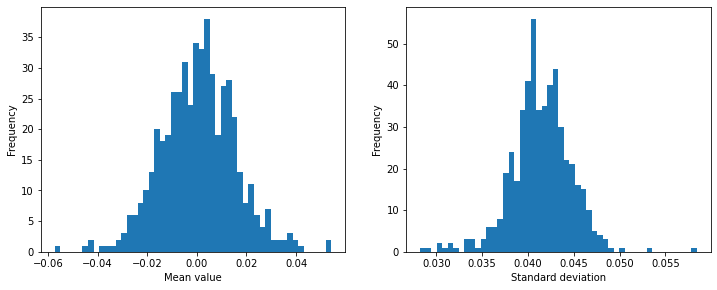

In [31]:
# Compute the mean value of the high-level features

fig,axes = plt.subplots(1,2,figsize=(12,4.5))

axes[0].hist(np.mean(embeddings,axis=0),bins=50)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Mean value');

# Compute the std value of the high-level features

axes[1].hist(np.std(embeddings,axis=0),bins=50)
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Standard deviation');

In [32]:
vmin_dict = {'Twitter':0.09,
             'politics':0.087,
             'Nike':0.093,
             'IT':0.092,
             'sports':0.089,
             'movies':0.098,
             'cable TV':0.09,
             'mobile devices':0.092,
             'DSLR cameras':0.093,
            'unlabeled':0.08,
             'car industry':0.088,
            'books':0.092,'cities':0.09,
             'dentist':0.09,'blogging':0.09,
            'food':0.09,'Warren Buffett':0.09, 'Bobby Flay':0.09}

selected_categories = ['Twitter','movies','cities','IT','books']

In [33]:
selected_categories

['Twitter', 'movies', 'cities', 'IT', 'books']

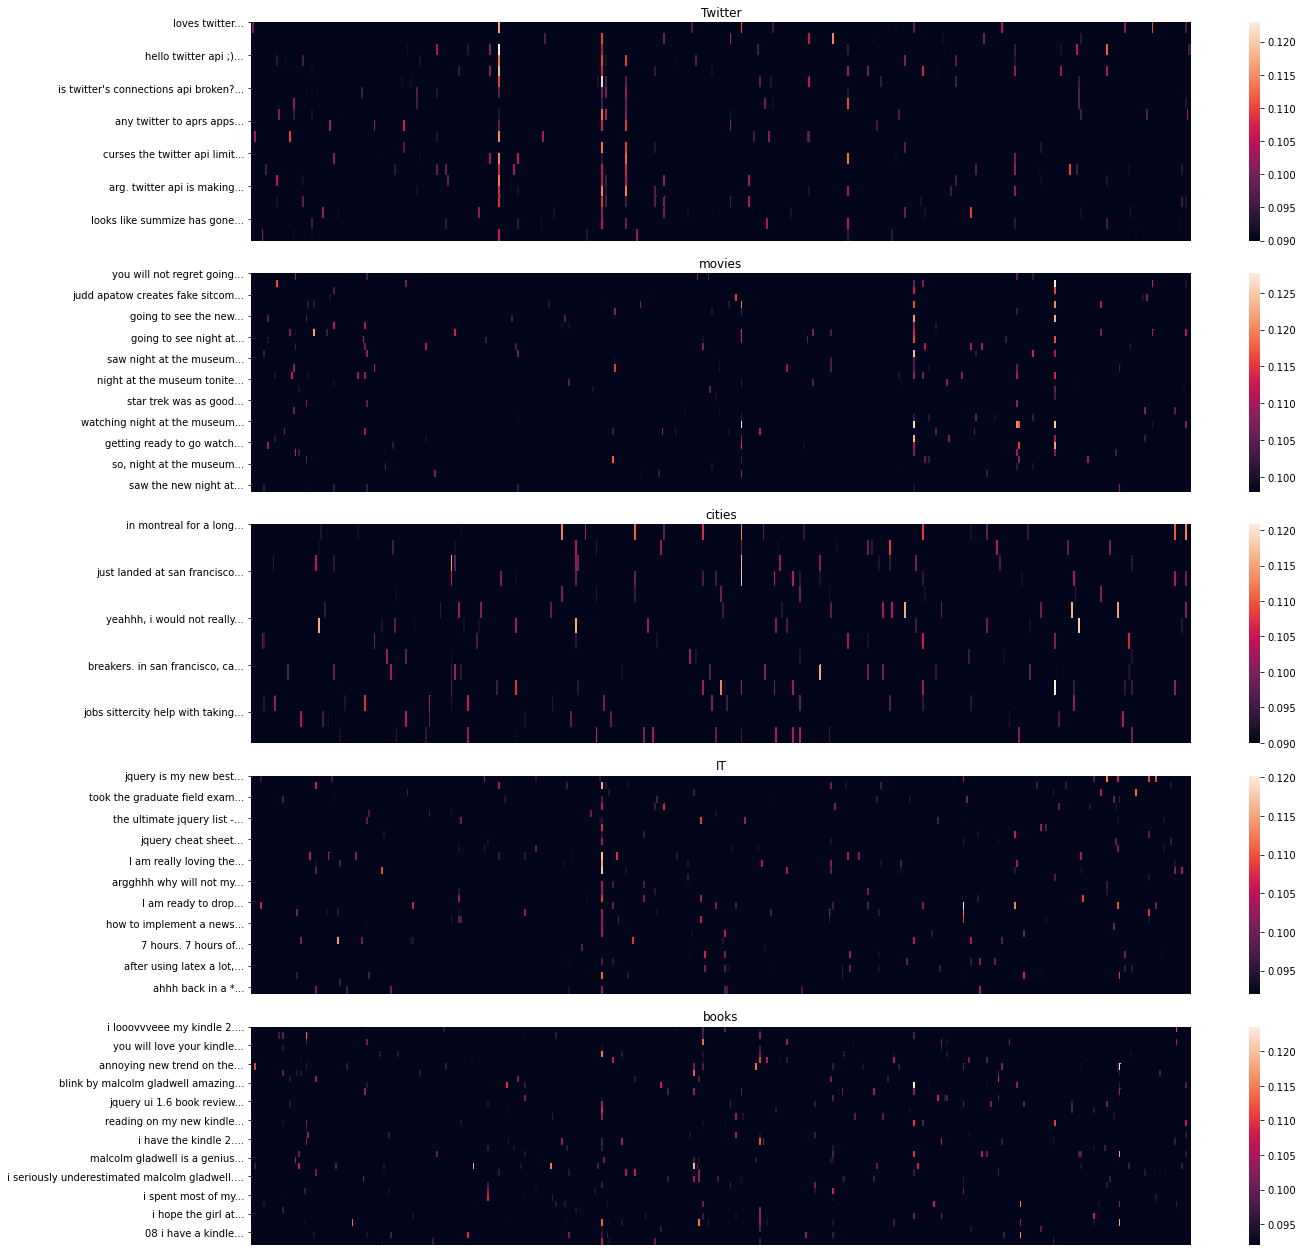

In [35]:
fig,axes = plt.subplots(len(selected_categories),1,figsize=(20,3.5*len(selected_categories)))

for cat,ax in zip(selected_categories,axes.ravel()):
    
    idx = df['semantic_category'] == cat
    
    X_plot = embeddings[idx]
    vmin = vmin_dict[cat]
    sns.heatmap(np.abs(X_plot),
                vmin=vmin,
                ax=ax)
    ax.set_title(cat)
    ax.set_yticks(ticks = np.arange(0,len(X_plot),3))
    
    ax.set_yticklabels(labels=[tools.clean_tweet_plot(tweet) for tweet in df.loc[idx,'tweet']][0:len(X_plot):3],rotation=0)
    ax.set_xticks([])
    
plt.tight_layout();

Tweets from similar, activate the same high-level feature.

In [36]:
# Export vectors

np.savez('data/word_vectors.npz',BOW_features=X_bow.toarray(),tfidf_features=X_tfidf.toarray(),embeddings = embeddings)